In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data/curated_data/final_crimes.csv')
df.columns

Index(['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude',
       'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type',
       'Last outcome category', 'Context'],
      dtype='object')

<Axes: xlabel='Crime type'>

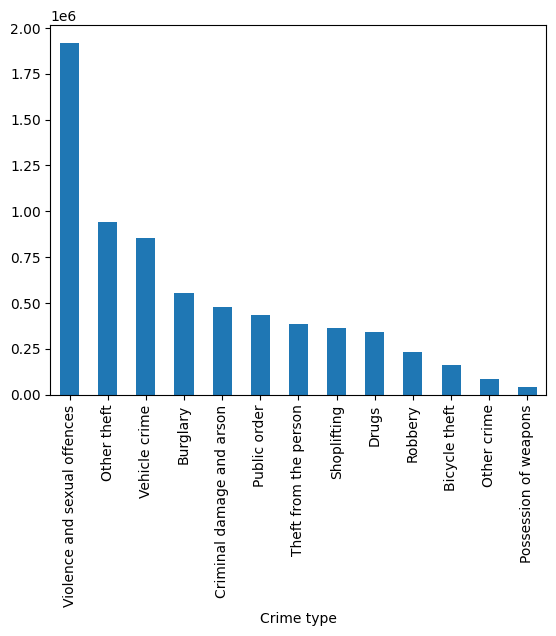

In [4]:
df['Crime type'].value_counts().plot(kind='bar')

<Axes: xlabel='Month'>

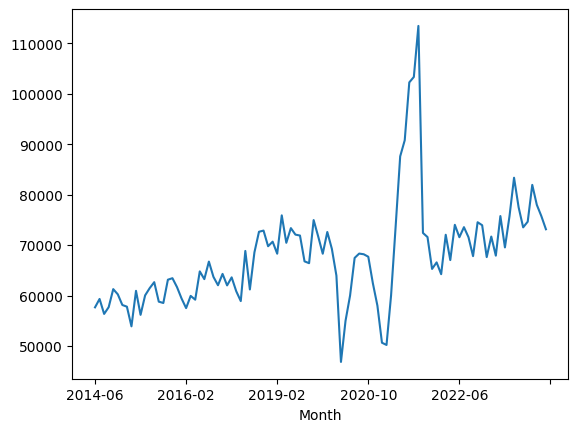

In [5]:
df.drop_duplicates(inplace=False)['Month'].value_counts().sort_index().plot(kind='line')
# .value_counts().sort_index().plot(kind='line')

### Survey data

In [6]:
column_map = {
    'Q150r':'sexuality', 'NQ149r': 'religion', 'NQ155r':'uk_citizen', 'NQ147r': 'ethnicity', 'Q136r':'age', 'XQ135r':'gender'
}

effectiveness_questions = ['Q79I', 'Q79B', 'Q79D', 'Q79E']
fairness_engagement_questions = ['Q62B', 'Q62C', 'A121']
accountability_questions = ['NQ135BH']
confidence_questions = ['Q65', 'Q21', 'Q131']

cols = ['MONTH', 'C2'] + ['Q150r', 'NQ149r', 'NQ155r', 'NQ147r', 'Q136r', 'XQ135r'] + effectiveness_questions + fairness_engagement_questions + accountability_questions + confidence_questions 

age_mapping = {'16-24': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65 or over': 6}


In [7]:
files = [
    "data/pas_data_ward_level/PAS_ward_level_FY_15_17.csv",
    "data/pas_data_ward_level/PAS_ward_level_FY_17_18.csv",
    "data/pas_data_ward_level/PAS_ward_level_FY_18_19.csv",
    "data/pas_data_ward_level/PAS_ward_level_FY_19_20.csv"
]

all_data = pd.DataFrame()

# survey_columns = [
#     'MONTH', 'C2',
#     'Q79I', 'Q79B', 'Q79D', 'Q79E',  # Effectiveness
#     'Q62B', 'Q62C', 'A121',  # Fairness and engagement
#     'NQ135BH',  # Accountability
#     'Q65', 'Q21', 'Q131'  # Confidence
# ]

dataframes = []
for file in files:
    try:

        df = pd.read_csv(file)
        
        cols_to_select = [col for col in cols if col in df.columns]
        selected_df = df[cols_to_select]
        
        dataframes.append(selected_df)
        print(f"Loaded {file} with selected columns.")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Combine all the dataframes
surveys_df = pd.concat(dataframes, ignore_index=True)

Loaded data/pas_data_ward_level/PAS_ward_level_FY_15_17.csv with selected columns.
Loaded data/pas_data_ward_level/PAS_ward_level_FY_17_18.csv with selected columns.
Loaded data/pas_data_ward_level/PAS_ward_level_FY_18_19.csv with selected columns.
Loaded data/pas_data_ward_level/PAS_ward_level_FY_19_20.csv with selected columns.


In [8]:
surveys_demographics = surveys_df[cols]

### Encode demographic data

In [9]:
surveys_demographics.columns = [column_map[x] if x in column_map.keys() else x for x in surveys_demographics.columns]

surveys_demographics['is_hetero'] = (surveys_demographics['sexuality'] == 'Heterosexual').astype(int)
surveys_demographics['is_uk'] = (surveys_demographics['uk_citizen'] == 'UK').astype(int)
surveys_demographics = pd.get_dummies(surveys_demographics, columns=['religion'], drop_first=True)
surveys_demographics = pd.get_dummies(surveys_demographics, columns=['ethnicity'], drop_first=True)
surveys_demographics = pd.get_dummies(surveys_demographics, columns=['gender'], drop_first=True)
surveys_demographics['age_range'] = surveys_demographics['age'].map(age_mapping)

In [10]:
surveys_demographics['uk_citizen'].value_counts()

uk_citizen
UK        35941
Non-UK    27013
Name: count, dtype: int64

In [11]:
column_map = {
    'Q150r':'sexuality', 'NQ149r': 'religion', 'NQ155r':'uk_citizen', 'NQ147r': 'ethnicity', 'Q136r':'age', 'XQ135r':'gender'
}

In [12]:
label_to_value_map = {
    '1 Not at all well': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7 Very well': 7,
    "Don't know": 97,
    'Refused': 98,
    'Not Asked': 99,

    'Strongly agree': 5,
    'Tend to agree': 4,
    'Neither agree nor disagree': 3,
    'Tend to disagree': 2,
    'Strongly disagree': 1,
    

    'Yes': 2,
    'No': 1,

    'Very confident': 4,
    'Fairly confident': 3,
    'Not very confident': 2,
    'Not at all confident': 1,

    'At least daily': 6,
    'At least weekly': 5,
    'At least fortnightly': 4,
    'At least monthly': 3,
    'Less often': 2,
    'Never': 1,

    'Very safe': 6,
    'Fairly safe': 5,
    'Fairly unsafe': 4,
    'Very unsafe': 2,
    '(spontaneous) Do not go out at all': 1,
    '(spontaneous) Do not go out alone': 3,

    'Very well informed': 3,
    'Fairly well informed': 2,
    'Not at all informed': 1
}

def label_to_value(label):
    return label_to_value_map.get(label, label)

In [13]:
questions = effectiveness_questions + fairness_engagement_questions + accountability_questions + confidence_questions

surveys_demographics[questions] = surveys_demographics[questions].applymap(label_to_value)



In [14]:
import seaborn as sns
import numpy as np
surveys_demographics.replace([97, 98, 99], np.nan, inplace=True)
# sns.heatmap(mock.isna())
# print(mock.dropna().shape)
surveys_demographics.dropna(inplace=True)

In [15]:
toselect = ['MONTH', 'C2', 'Q79I',
 'Q79B',
 'Q79D',
 'Q79E',
 'Q62B',
 'Q62C',
 'A121',
 'NQ135BH',
 'Q65',
 'Q21',
 'Q131',
 'is_hetero',
 'is_uk',
 'religion_Hindu',
 'religion_Muslim',
 'religion_No religion',
 'religion_Other religion',
 'ethnicity_Black',
 'ethnicity_Mixed',
 'ethnicity_Other',
 'ethnicity_White British',
 'ethnicity_White Other',
 'gender_Male',
 'gender_Other',
 'age_range']

surveys_demographics = surveys_demographics[toselect]


In [16]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.formula.api import ols

In [17]:
# independent_vars = [
#     'is_hetero', 'is_uk', 
#     'Q("religion_Hindu")', 'Q("religion_Muslim")', 'Q("religion_No religion")', 'Q("religion_Other religion")',
#     'Q("ethnicity_Black")', 'Q("ethnicity_Mixed")', 'Q("ethnicity_Other")', 'Q("ethnicity_White British")', 'Q("ethnicity_White Other")',
#     'gender_Male', 'gender_Other', 
#     'age_range'
# ]

# formula_parts = ['Q131 ~ '] + independent_vars
# formula = ' + '.join(formula_parts) + ' + ' + ' + '.join(f'{v1}:{v2}' for v1 in independent_vars for v2 in independent_vars if v1 != v2)
# model = ols(formula, data=surveys_demographics).fit()
# print(model.summary())

In [18]:
def adjust_Q79I(row):
    adjustment = 0

    # Main effects
    if row['ethnicity_White British'] == 1:
        adjustment += 11.9952

    # Interaction effects
    if row['is_uk'] == 1 and row['ethnicity_Black'] == 1:
        adjustment += -7.9211
    if row['is_uk'] == 1 and row['ethnicity_White British'] == 1:
        adjustment += -11.5516
    if row['is_hetero'] == 1 and row['gender_Other'] == 1:
        adjustment += 102.0781
    if row['religion_Muslim'] == 1 and row['gender_Other'] == 1:
        adjustment += -3.919e-13  # This is effectively zero and can be ignored
    if row['religion_No religion'] == 1 and row['ethnicity_Other'] == 1:
        adjustment += 7.7939
    if row['religion_Other religion'] == 1 and row['ethnicity_Other'] == 1:
        adjustment += 11.9128
    if row['religion_Other religion'] == 1 and row['gender_Male'] == 1:
        adjustment += 4.2869

    # Apply the adjustment to the original Q79I response
    adjusted_response = row['Q79I'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q79I'] = surveys_demographics.apply(adjust_Q79I, axis=1)

In [19]:
def adjustQ79B(row):
    adjustment = 0

    # Main effects
    if row['is_uk'] == 1:
        adjustment += -0.4738
    if row['ethnicity_Black'] == 1:
        adjustment += -0.5863
    if row['gender_Other'] == 1:
        adjustment += -3.9287

    # Interaction effects
    if row['is_hetero'] == 1 and row['ethnicity_White British'] == 1:
        adjustment += -0.2297
    if row['is_uk'] == 1 and row['ethnicity_Black'] == 1:
        adjustment += -0.1465
    if row['is_uk'] == 1 and row['ethnicity_White British'] == 1:
        adjustment += 0.1248
    if row['religion_Muslim'] == 1 and row['ethnicity_Black'] == 1:
        adjustment += 0.2666
    if row['religion_Muslim'] == 1 and row['ethnicity_Mixed'] == 1:
        adjustment += 0.4384
    if row['religion_Muslim'] == 1 and row['ethnicity_Other'] == 1:
        adjustment += 0.1868
    if row['religion_Muslim'] == 1 and row['gender_Other'] == 1:
        adjustment += -1.322e-14  # This is effectively zero and can be ignored
    if row['religion_No religion'] == 1 and row['ethnicity_Black'] == 1:
        adjustment += 0.1846
    if row['religion_Other religion'] == 1 and row['ethnicity_Mixed'] == 1:
        adjustment += 0.4532
    if row['gender_Other'] == 1 and row['age_range'] != None:
        adjustment += 0.8285 * row['age_range']  # assuming age_range is scaled appropriately

    # Apply the adjustment to the original Q79B response
    adjusted_response = row['Q79B'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q79B'] = surveys_demographics.apply(adjustQ79B, axis=1)

In [20]:
def apply_Q79D(row):
    adjustment = 0

    # Main effects
    if row['is_uk']:
        adjustment += -0.5579
    if row['ethnicity_Black']:
        adjustment += -0.6811
    if row['ethnicity_White British']:
        adjustment += -0.3519
    if row['ethnicity_White Other']:
        adjustment += -0.2897
    if row['age_range'] is not None:
        adjustment += -0.0715 * row['age_range']

    # Interaction effects
    if row['is_hetero'] and row['ethnicity_Mixed']:
        adjustment += -0.3923
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += 0.3674
    if row['is_uk'] and row['gender_Male']:
        adjustment += 0.0763
    if row['religion_Muslim'] and row['ethnicity_Black']:
        adjustment += 0.2895
    if row['religion_Muslim'] and row['ethnicity_Mixed']:
        adjustment += 0.3117
    if row['religion_Other religion'] and row['ethnicity_Black']:
        adjustment += -0.5389
    if row['religion_Other religion'] and row['ethnicity_Mixed']:
        adjustment += 0.4505

    # Apply the adjustment to the original Q79D response
    adjusted_response = row['Q79D'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q79D'] = surveys_demographics.apply(apply_Q79D, axis=1)


In [21]:
def apply_Q79E(row):
    adjustment = 0

    # Main effects
    if row['is_uk']:
        adjustment += -0.6151
    if row['ethnicity_Black']:
        adjustment += -0.8268
    if row['ethnicity_White British']:
        adjustment += -0.3697
    if row['ethnicity_White Other']:
        adjustment += -0.2511
    if row['age_range'] is not None:
        adjustment += -0.0896 * row['age_range']

    # Interaction effects
    if row['is_hetero'] and row['ethnicity_Black']:
        adjustment += 0.2552
    if row['is_hetero'] and row['gender_Other']:
        adjustment += 3.4662
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += 0.4410
    if row['religion_Hindu'] and row['religion_Other religion']:
        adjustment += 1.366e-14
    if row['religion_Muslim'] and row['ethnicity_Black']:
        adjustment += 0.3045
    if row['religion_Muslim'] and row['ethnicity_Mixed']:
        adjustment += 0.3155
    if row['religion_Other religion'] and row['ethnicity_Black']:
        adjustment += -0.4747
    if row['ethnicity_Mixed'] and row['gender_Other']:
        adjustment += 4.9951

    # Apply the adjustment to the original Q79E response
    adjusted_response = row['Q79E'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q79E'] = surveys_demographics.apply(apply_Q79E, axis=1)

In [22]:
def apply_Q62B(row):
    adjustment = 0

    # Main effects
    if row['is_uk']:
        adjustment += -0.2783
    if row['ethnicity_Black']:
        adjustment += -0.2289

    # Interaction effects
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += 0.1994
    if row['religion_Hindu'] and row['ethnicity_Other']:
        adjustment += -0.3091
    if row['religion_Muslim'] and row['ethnicity_Mixed']:
        adjustment += 0.1767
    if row['religion_Muslim'] and row['age_range'] is not None:
        adjustment += 0.0259 * row['age_range']
    if row['religion_No religion'] and row['age_range'] is not None:
        adjustment += -0.0345 * row['age_range']
    if row['religion_Other religion'] and row['ethnicity_Black']:
        adjustment += -0.1751
    if row['religion_Other religion'] and row['ethnicity_Mixed']:
        adjustment += 0.2160
    if row['religion_Other religion'] and row['gender_Other']:
        adjustment += -5.14e-16
    if row['gender_Male'] and row['age_range'] is not None:
        adjustment += -0.0091 * row['age_range']

    # Apply the adjustment to the original Q62B response
    adjusted_response = row['Q62B'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q62B'] = surveys_demographics.apply(apply_Q62B, axis=1)


In [23]:
def apply_Q62C(row):
    adjustment = 0

    # Main effects
    if row['is_hetero']:
        adjustment += 0.2519
    if row['is_uk']:
        adjustment += -0.4766
    if row['ethnicity_Black']:
        adjustment += -0.3972

    # Interaction effects
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += 0.3184
    if row['is_uk'] and row['gender_Male']:
        adjustment += 0.0930
    if row['is_uk'] and row['age_range'] is not None:
        adjustment += 0.0263 * row['age_range']
    if row['religion_Muslim'] and row['ethnicity_Black']:
        adjustment += 0.1593
    if row['religion_Muslim'] and row['gender_Male']:
        adjustment += -0.0897
    if row['religion_Muslim'] and row['age_range'] is not None:
        adjustment += 0.0247 * row['age_range']
    if row['religion_Other religion'] and row['ethnicity_Black']:
        adjustment += -0.5451
    if row['religion_Other religion'] and row['ethnicity_White British']:
        adjustment += -0.2072
    if row['religion_No religion'] and row['age_range'] is not None:
        adjustment += -0.0391 * row['age_range']
    if row['gender_Male'] and row['age_range'] is not None:
        adjustment += -0.0122 * row['age_range']
    if row['ethnicity_White Other'] and row['gender_Other']:
        adjustment += -2.1980

    # Apply the adjustment to the original Q62C response
    adjusted_response = row['Q62C'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q62C'] = surveys_demographics.apply(apply_Q62C, axis=1)


In [24]:
def apply_A121(row):
    adjustment = 0

    # Main effects
    if row['is_hetero']:
        adjustment += 0.2989
    if row['is_uk']:
        adjustment += -0.3404
    if row['ethnicity_Black']:
        adjustment += -0.3090
    if row['gender_Other']:
        adjustment += -1.9573
    if row['religion_Muslim']:
        adjustment += 0.2123

    # Interaction effects
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += 0.1971
    if row['is_uk'] and row['gender_Male']:
        adjustment += 0.0648
    if row['is_uk'] and row['age_range'] is not None:
        adjustment += 0.0302 * row['age_range']
    if row['is_hetero'] and row['gender_Male']:
        adjustment += -0.0687
    if row['religion_Muslim'] and row['ethnicity_Black']:
        adjustment += 0.1214
    if row['religion_Muslim'] and row['ethnicity_White British']:
        adjustment += -0.1770
    if row['religion_Muslim'] and row['gender_Male']:
        adjustment += -0.0604
    if row['religion_No religion'] and row['ethnicity_White British']:
        adjustment += -0.1121
    if row['religion_No religion'] and row['ethnicity_White Other']:
        adjustment += -0.1506
    if row['religion_No religion'] and row['age_range'] is not None:
        adjustment += -0.0221 * row['age_range']
    if row['religion_Other religion'] and row['ethnicity_Black']:
        adjustment += -0.2855
    if row['religion_Other religion'] and row['ethnicity_White British']:
        adjustment += -0.1774
    if row['religion_Other religion'] and row['ethnicity_White Other']:
        adjustment += -0.1291
    if row['gender_Male'] and row['age_range'] is not None:
        adjustment += 0.0118 * row['age_range']

    # Apply the adjustment to the original A121 response
    adjusted_response = row['A121'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_A121'] = surveys_demographics.apply(apply_A121, axis=1)



In [25]:
def apply_NQ135BH(row):
    adjustment = 0

    # Interaction effects with significant p-values
    if row['is_uk'] and row['ethnicity_Black']:
        adjustment += -7.8897
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += -11.7729
    if row['religion_Other religion'] and row['ethnicity_Other']:
        adjustment += 13.5283
    if row['religion_Muslim'] and row['age_range'] is not None:
        adjustment += -1.4949 * row['age_range']
    if row['religion_Other religion'] and row['gender_Other']:
        adjustment += -3.409e-14

    # Apply the adjustment to the original NQ135BH response
    adjusted_response = row['NQ135BH'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_NQ135BH'] = surveys_demographics.apply(apply_NQ135BH, axis=1)


In [26]:
surveys_demographics

,MONTH,C2,Q79I,Q79B,Q79D,Q79E,Q62B,Q62C,A121,NQ135BH,...,gender_Other,age_range,adjusted_Q79I,adjusted_Q79B,adjusted_Q79D,adjusted_Q79E,adjusted_Q62B,adjusted_Q62C,adjusted_A121,adjusted_NQ135BH
16048,64 (Jul 2016),Merton,5.0,6.0,4.0,4.0,5.0,5.0,2.0,5.0,...,False,4.0,5.4436,5.4213,3.2479,3.0978,4.8847,5.2431,2.3197,-6.7729
16049,64 (Jul 2016),Merton,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,...,False,2.0,5.4436,4.4213,4.3909,4.2770,4.8339,4.1367,4.0794,-7.7729
16050,64 (Jul 2016),Merton,3.0,5.0,5.0,3.0,2.0,1.0,3.0,4.0,...,False,4.0,3.4436,4.4213,4.2479,2.0978,1.8847,1.2431,3.3197,-7.7729
16053,64 (Jul 2016),Newham,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,...,False,1.0,-3.9211,2.7934,2.6895,2.7237,3.4928,3.4044,2.6797,-3.8897
16054,64 (Jul 2016),Newham,6.0,6.0,6.0,6.0,4.0,4.0,3.0,4.0,...,False,2.0,6.0000,6.0000,5.5673,5.5697,3.9818,4.2275,3.2538,4.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63657,108 (Mar 2020),Croydon,5.0,6.0,5.0,4.0,5.0,4.0,3.0,5.0,...,False,6.0,5.4436,5.4213,4.1049,2.9186,4.8665,4.2713,3.4037,-6.7729
63658,108 (Mar 2020),Croydon,7.0,7.0,7.0,5.0,5.0,5.0,3.0,5.0,...,False,6.0,7.0000,7.0000,6.2813,4.2113,4.9454,5.1787,3.3010,5.0000
63659,108 (Mar 2020),Croydon,3.0,5.0,5.0,3.0,4.0,4.0,3.0,5.0,...,False,1.0,-4.9211,3.7934,3.7658,1.7237,3.4837,3.4852,2.6876,-2.8897
63660,108 (Mar 2020),Barking and Dagenham,5.0,7.0,5.0,7.0,5.0,5.0,4.0,5.0,...,False,3.0,5.4436,6.4213,4.2431,6.1874,4.9211,5.1726,4.2462,-6.7729


In [27]:
def apply_Q65(row):
    base_value = 4.0303  # Intercept
    adjustment = 0

    # Apply adjustments
    adjustment += row.get('is_hetero', 0) * (-0.2577)
    adjustment += row.get('is_uk', 0) * (-0.6862)
    adjustment += row.get('ethnicity_White Other', 0) * (-0.3747)
    adjustment += row.get('gender_Male', 0) * 0.2339
    adjustment += row.get('age_range', 0) * (-0.1657)

    # Calculate final Q65 value
    final_q65 = base_value + adjustment
    return final_q65

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q65'] = surveys_demographics.apply(apply_Q65, axis=1)


In [28]:
def apply_Q21(row):
    base_value = 5.5248  # Intercept from the regression model
    adjustment = 0

    # Adjustments based on significant predictors using dummy variables
    adjustment += row.get('is_hetero', 0) * (-0.2826)
    adjustment += row.get('is_uk', 0) * (-0.3778)
    adjustment += row.get('religion_Muslim', 0) * (-0.6364)
    adjustment += row.get('religion_No religion', 0) * (-0.1791)
    adjustment += row.get('religion_Other religion', 0) * (-0.4015)
    adjustment += row.get('ethnicity_Black', 0) * (-0.3826)
    adjustment += row.get('ethnicity_Mixed', 0) * (-0.4245)
    adjustment += row.get('ethnicity_White Other', 0) * (-0.2529)
    adjustment += row.get('gender_Male', 0) * 0.1579

    # Calculate the final Q21 value
    final_q21 = base_value + adjustment
    return final_q21

       
surveys_demographics['adjusted_Q21'] = surveys_demographics.apply(apply_Q21, axis=1)


In [29]:
def apply_Q131(row):
    base_value = 1.4633  # Intercept
    adjustment = 0

    # Apply adjustments
    adjustment += row.get('is_uk', 0) * (-0.0959)
    adjustment += row.get('ethnicity_White Other', 0) * (-0.1221)

    # Calculate final Q131 value
    final_q131 = base_value + adjustment
    return final_q131

surveys_demographics['adjusted_Q131'] = surveys_demographics.apply(apply_Q131, axis=1)



In [30]:
surveys_demographics

,MONTH,C2,Q79I,Q79B,Q79D,Q79E,Q62B,Q62C,A121,NQ135BH,...,adjusted_Q79B,adjusted_Q79D,adjusted_Q79E,adjusted_Q62B,adjusted_Q62C,adjusted_A121,adjusted_NQ135BH,adjusted_Q65,adjusted_Q21,adjusted_Q131
16048,64 (Jul 2016),Merton,5.0,6.0,4.0,4.0,5.0,5.0,2.0,5.0,...,5.4213,3.2479,3.0978,4.8847,5.2431,2.3197,-6.7729,2.6575,5.0223,1.3674
16049,64 (Jul 2016),Merton,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,...,4.4213,4.3909,4.2770,4.8339,4.1367,4.0794,-7.7729,2.9889,4.8432,1.3674
16050,64 (Jul 2016),Merton,3.0,5.0,5.0,3.0,2.0,1.0,3.0,4.0,...,4.4213,4.2479,2.0978,1.8847,1.2431,3.3197,-7.7729,2.6575,5.0223,1.3674
16053,64 (Jul 2016),Newham,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,...,2.7934,2.6895,2.7237,3.4928,3.4044,2.6797,-3.8897,2.9207,4.4818,1.3674
16054,64 (Jul 2016),Newham,6.0,6.0,6.0,6.0,4.0,4.0,3.0,4.0,...,6.0000,5.5673,5.5697,3.9818,4.2275,3.2538,4.0000,3.3004,5.1472,1.3412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63657,108 (Mar 2020),Croydon,5.0,6.0,5.0,4.0,5.0,4.0,3.0,5.0,...,5.4213,4.1049,2.9186,4.8665,4.2713,3.4037,-6.7729,2.3261,5.0223,1.3674
63658,108 (Mar 2020),Croydon,7.0,7.0,7.0,5.0,5.0,5.0,3.0,5.0,...,7.0000,6.2813,4.2113,4.9454,5.1787,3.3010,5.0000,2.6376,5.1472,1.3412
63659,108 (Mar 2020),Croydon,3.0,5.0,5.0,3.0,4.0,4.0,3.0,5.0,...,3.7934,3.7658,1.7237,3.4837,3.4852,2.6876,-2.8897,3.1546,4.6397,1.3674
63660,108 (Mar 2020),Barking and Dagenham,5.0,7.0,5.0,7.0,5.0,5.0,4.0,5.0,...,6.4213,4.2431,6.1874,4.9211,5.1726,4.2462,-6.7729,2.5893,4.8644,1.3674


### Mappings

In [31]:
"""
    TODO:
    1. Apply column aggregation on 'wrong' dataframes
    2. Merge dataframes from all years
    3. Run statistical analysis on merged dataframe
"""

"\n    TODO:\n    1. Apply column aggregation on 'wrong' dataframes\n    2. Merge dataframes from all years\n    3. Run statistical analysis on merged dataframe\n"

In [32]:
from sklearn.preprocessing import MinMaxScaler

def scale_columns(dataframe, columns_to_scale):
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Apply the scaler to the selected columns and replace in dataframe
    dataframe[columns_to_scale] = scaler.fit_transform(dataframe[columns_to_scale])

    return dataframe

In [33]:
cols2 = ['adjusted_Q79I', 'adjusted_Q79B',
       'adjusted_Q79D', 'adjusted_Q79E', 'adjusted_Q62B', 'adjusted_Q62C',
       'adjusted_A121', 'adjusted_NQ135BH', 'adjusted_Q65', 'adjusted_Q21',
       'adjusted_Q131']

In [34]:
scaled_surveys_demographics = scale_columns(surveys_demographics, cols2)

In [35]:
grouped = scaled_surveys_demographics.groupby(['MONTH', 'C2']).median().reset_index()

effectiveness_questions = ['adjusted_Q79I', 'adjusted_Q79B',
       'adjusted_Q79D', 'adjusted_Q79E']
fairness_engagement_questions = ['adjusted_Q62B', 'adjusted_Q62C',
       'adjusted_A121']
accountability_questions = ['adjusted_NQ135BH']
confidence_questions = ['adjusted_Q65', 'adjusted_Q21',
       'adjusted_Q131']

# MAKE SURE MEAN IS CORRECT
grouped['Effectiveness'] = grouped[effectiveness_questions].mean(axis=1)
grouped['Fairness and Engagement'] = grouped[fairness_engagement_questions].mean(axis=1)
grouped['Accountability'] = grouped[accountability_questions].mean(axis=1)
grouped['Confidence Questions'] = grouped[confidence_questions].mean(axis=1)

# Calculate 'Trust' as the mean of the first three categories
grouped['Trust'] = grouped[['Effectiveness', 'Fairness and Engagement', 'Accountability']].mean(axis=1)

# Update 'Confidence' to be the mean of itself and 'Trust'
grouped['Confidence'] = grouped[['Confidence Questions', 'Trust']].mean(axis=1)

In [36]:
# Change the format of the month
grouped['Date'] = pd.to_datetime(grouped['MONTH'].str.extract(r'\((.*?)\)')[0], format='%b %Y')
grouped.sort_values('Date', inplace=True)
grouped['MONTH'] = grouped['Date'].dt.strftime('%b %Y')

In [37]:
final_grouped = grouped.groupby(['MONTH', 'C2']).mean().reset_index()

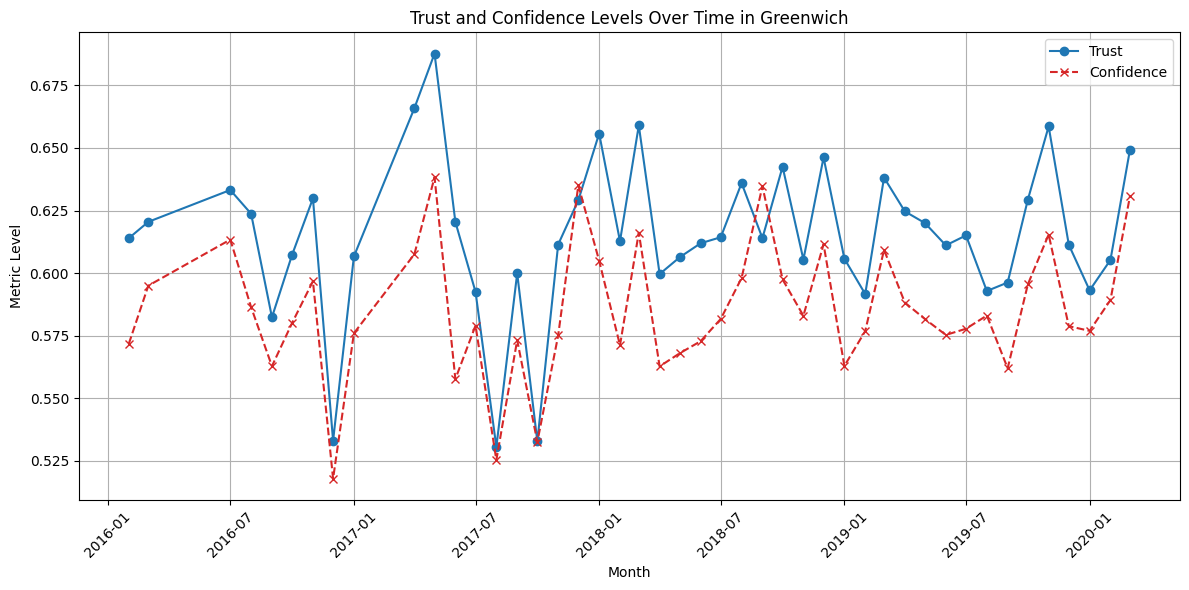

In [38]:
borough_data = final_grouped[final_grouped['C2'] == 'Westminster']
borough_data['MONTH'] = pd.to_datetime(borough_data['MONTH'], format='%b %Y')
borough_data.sort_values('MONTH', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(borough_data['MONTH'], borough_data['Trust'], color='tab:blue', marker='o', linestyle='-', label='Trust')
plt.plot(borough_data['MONTH'], borough_data['Confidence'], color='tab:red', marker='x', linestyle='--', label='Confidence')

plt.title('Trust and Confidence Levels Over Time in Westminster')
plt.xlabel('Month')
plt.ylabel('Metric Level')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

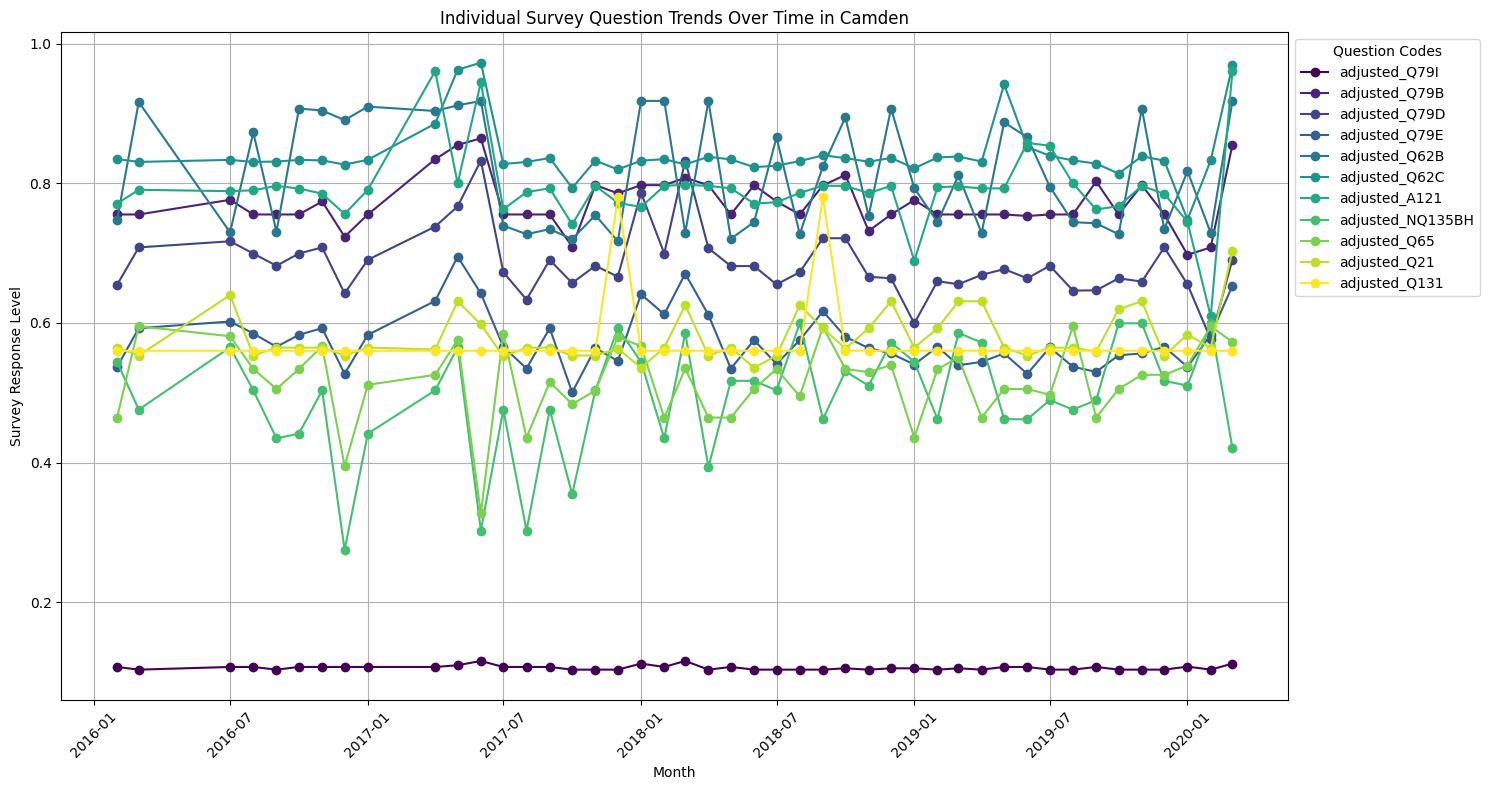

In [39]:
camden_data = final_grouped[final_grouped['C2'] == 'Westminster']
camden_data['MONTH'] = pd.to_datetime(camden_data['MONTH'], format='%b %Y')
camden_data = camden_data.sort_values('MONTH')

question_columns = ['Q79I', 'Q79B', 'Q79D', 'Q79E', 'Q62B', 'Q62C', 'A121', 'NQ135BH', 'Q65', 'Q21', 'Q131']

# Q79D has an issue

plt.figure(figsize=(15, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(cols2)))
for i, col in enumerate(cols2):
    plt.plot(camden_data['MONTH'], camden_data[col], label=col, color=colors[i], marker='o', linestyle='-')

plt.title('Individual Survey Question Trends Over Time in Camden')
plt.xlabel('Month')
plt.ylabel('Survey Response Level')
plt.legend(title='Question Codes', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
PAS_file_path = "data/PAS_T&Cdashboard_to Q3 23-24.xlsx"
df_PAS = pd.read_excel(PAS_file_path, sheet_name='Borough')

trust_data = df_PAS[df_PAS['Measure'] == 'Trust MPS']

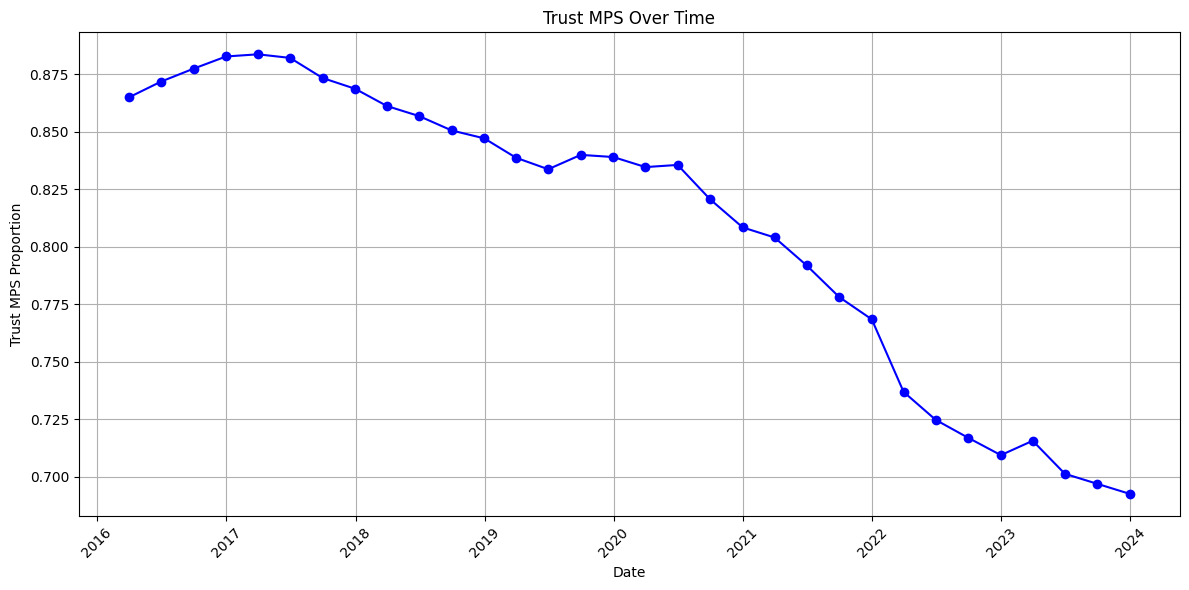

In [41]:
trust_mps_over_time = trust_data.groupby('Date')['Proportion'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(trust_mps_over_time['Date'], trust_mps_over_time['Proportion'], marker='o', linestyle='-', color='blue')
plt.title('Trust MPS Over Time')
plt.xlabel('Date')
plt.ylabel('Trust MPS Proportion')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

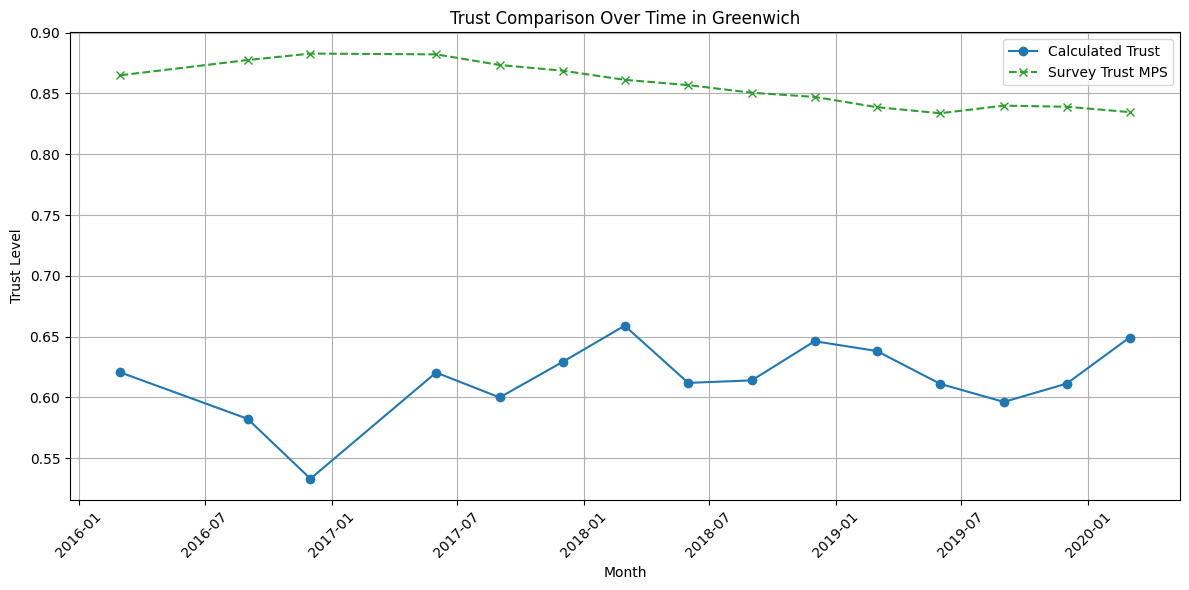

In [42]:
# PAS_file_path = "C:/Users/20220678/Microsoft VS Code/JBG050-DC2-Grp21/data/PAS_T&Cdashboard_to Q3 23-24.xlsx"
# df_PAS = pd.read_excel(PAS_file_path, sheet_name='Borough')

# trust_data = df_PAS[df_PAS['Measure'] == 'Trust MPS']
trust_mps_over_time['Date'] = pd.to_datetime(trust_mps_over_time['Date'], dayfirst=True)

# Change the Date to the start of the month to match with 'MONTH' in final_grouped
trust_mps_over_time['Month'] = trust_mps_over_time['Date'].dt.to_period('M').dt.to_timestamp()

combined_data_trust = pd.merge(borough_data, trust_mps_over_time[['Month', 'Proportion']], left_on='MONTH', right_on='Month', how='inner')

# Rename
combined_data_trust.rename(columns={'Proportion': 'Trust MPS'}, inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(combined_data_trust['MONTH'], combined_data_trust['Trust'], color='tab:blue', marker='o', linestyle='-', label='Calculated Trust')
plt.plot(combined_data_trust['MONTH'], combined_data_trust['Trust MPS'], color='tab:green', marker='x', linestyle='--', label='Survey Trust MPS')
plt.title('Trust Comparison Over Time in Greenwich')
plt.xlabel('Month')
plt.ylabel('Trust Level')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
# Calculate correlation
correlation = combined_data_trust[['Trust', 'Confidence']].corr()
print("Correlation between Calculated Trust and Trust MPS:")
print(correlation)

Correlation between Calculated Trust and Trust MPS:
               Trust  Confidence
Trust       1.000000    0.814304
Confidence  0.814304    1.000000


In [44]:
# Calculate correlation
correlation = combined_data_trust[['Trust', 'Trust MPS']].corr()
print("Correlation between Calculated Trust and Trust MPS:")
print(correlation)

Correlation between Calculated Trust and Trust MPS:
              Trust  Trust MPS
Trust      1.000000  -0.462922
Trust MPS -0.462922   1.000000


### Correlation of determinants of trust and confidence against Trust MPS

In [45]:
# effectiveness = grouped.groupby('Date').mean()[['Effectiveness']]
# fairness_engagement = grouped.groupby('Date').mean()[['Fairness and Engagement']]
# accountability = grouped.groupby('Date').mean()[['Accountability']]
# trust = grouped.groupby('Date').mean()[['Trust']]

# plt.plot(trust_mps_over_time[trust_mps_over_time['Date'] < '2021']['Date'],trust_mps_over_time[trust_mps_over_time['Date'] < '2021']['Proportion']  , label = "Trust MPS")
# plt.plot(effectiveness.reset_index()['Date'], effectiveness.reset_index()['Effectiveness'], label='Effectiveness')
# plt.plot(fairness_engagement.reset_index()['Date'], fairness_engagement.reset_index()['Fairness and Engagement'], label='Fairness and Engagement')
# plt.plot(accountability.reset_index()['Date'], accountability.reset_index()['Accountability'], label='Accountability')
# plt.plot(trust.reset_index()['Date'], trust.reset_index()['Trust'], label='trust')

# plt.xlabel('Date')
# plt.ylabel('Values')
# plt.legend()
# plt.grid(True)

## Analyzing trends in crimes

In [46]:
final_grouped.to_csv('data/curated_data/final_grouped.csv', index=False)

In [79]:
# Plot crimes over time and compare with trust and confidence over time

crimes = pd.read_csv('data/curated_data/final_crimes.csv')

In [80]:
crime_outcomes_mapping = {
    "Investigation complete; no suspect identified": "unresolved",
    "Suspect charged": "resolved",
    "Local resolution": "resolved",
    "Offender given a caution": "resolved",
    "Offender given a drugs possession warning": "resolved",
    "Offender given penalty notice": "resolved",
    "Offender sent to prison": "resolved",
    "Defendant found not guilty": "resolved",
    "Offender given community sentence": "resolved",
    "Offender fined": "resolved",
    "Offender given suspended prison sentence": "resolved",
    "Offender given conditional discharge": "resolved",
    "Court case unable to proceed": "unresolved",
    "Offender otherwise dealt with": "resolved",
    "Offender ordered to pay compensation": "resolved",
    "Offender deprived of property": "resolved",
    "Suspect charged as part of another case": "resolved",
    "Offender given absolute discharge": "resolved",
    "Defendant sent to Crown Court": "resolved",
    "Formal action is not in the public interest": "resolved",
    "Unable to prosecute suspect": "unresolved"
}

crimes['Outcome'] = crimes['Last outcome category'].map(crime_outcomes_mapping)

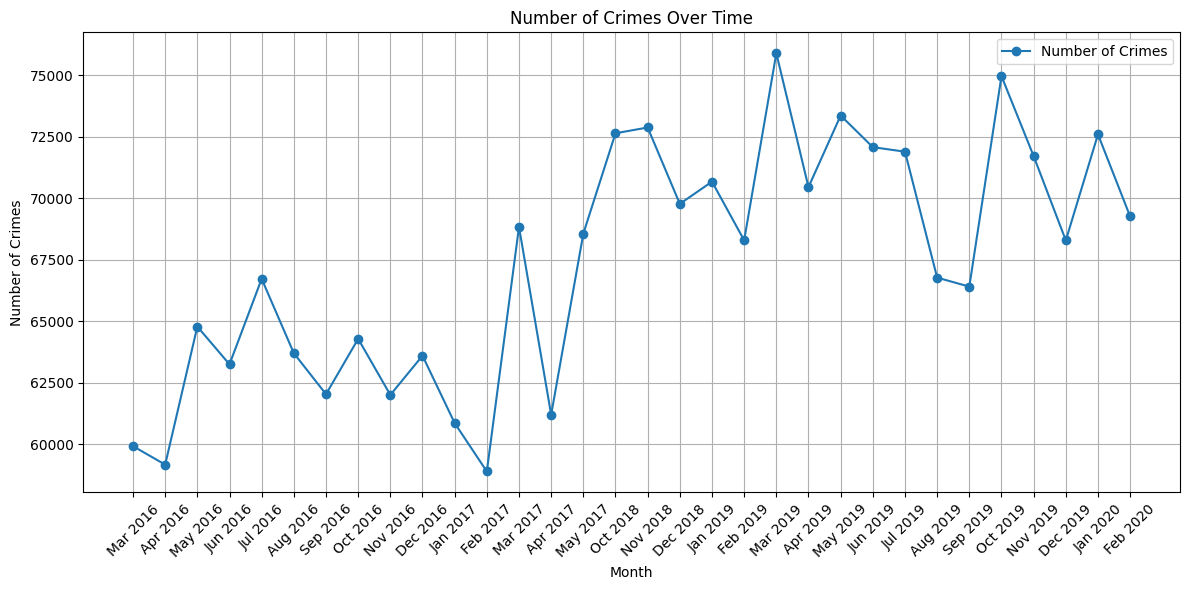

In [81]:
# Plot crimes over time and compare with trust and confidence over time

crimes['Month'] = pd.to_datetime(crimes['Month'], format='%Y-%m')
crimes = crimes[(crimes['Month'] > '2016-02-01') & (crimes['Month'] < '2020-03-01')]
crimes_over_time = crimes.groupby('Month').size().reset_index(name='Number of Crimes')
crimes_over_time = crimes_over_time.sort_values('Month')
crimes_over_time['Month'] = crimes_over_time['Month'].dt.strftime('%b %Y')


plt.figure(figsize=(12, 6))
plt.plot(crimes_over_time['Month'], crimes_over_time['Number of Crimes'], color='tab:blue', marker='o', linestyle='-', label='Number of Crimes')
plt.title('Number of Crimes Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [82]:
# Get median trust and confidence for ALL boroughs

trust_conf_grouped = final_grouped.groupby('Date')[['Trust', 'Confidence']].median().reset_index()
trust_conf_grouped['Date'] = trust_conf_grouped['Date'].dt.strftime('%b %Y')

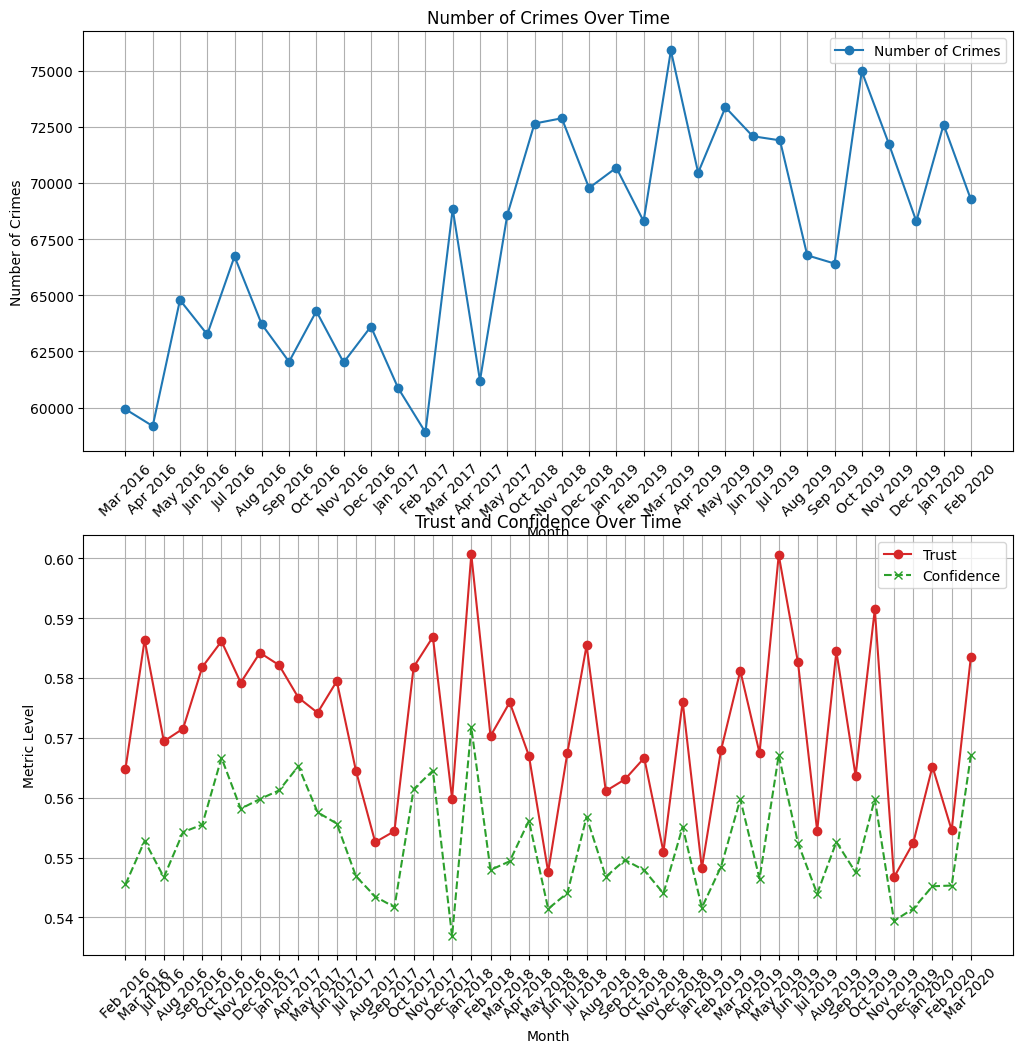

In [83]:
# do a subplot with the plot above, and a second plot with trust and confidence

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(crimes_over_time['Month'], crimes_over_time['Number of Crimes'], color='tab:blue', marker='o', linestyle='-', label='Number of Crimes')
ax[0].set_title('Number of Crimes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of Crimes')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Trust'], color='tab:red', marker='o', linestyle='-', label='Trust')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Confidence'], color='tab:green', marker='x', linestyle='--', label='Confidence')
ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

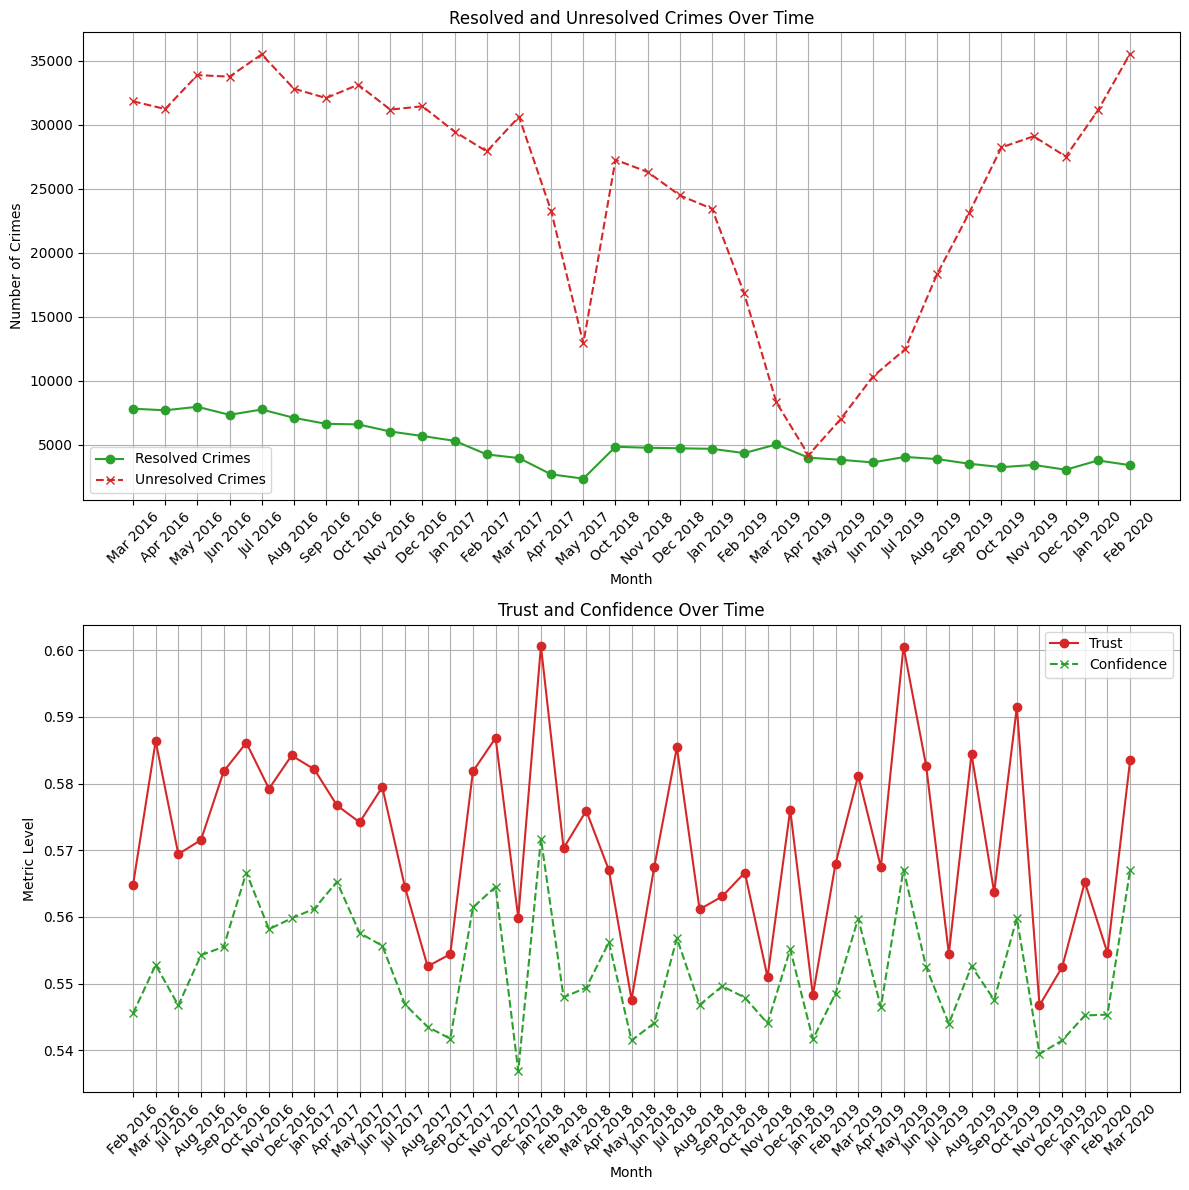

In [84]:
# instead of crimes over time against trust and confidence
# plot outcomes (by category, resolved and unresolved) over time against trust and confidence in subplots

outcomes_over_time = crimes.groupby(['Month', 'Outcome']).size().reset_index(name='Count')
outcomes_over_time = outcomes_over_time.pivot(index='Month', columns='Outcome', values='Count').reset_index()
outcomes_over_time = outcomes_over_time.fillna(0)
outcomes_over_time['Month'] = pd.to_datetime(outcomes_over_time['Month'], format='%Y-%m')
outcomes_over_time = outcomes_over_time[(outcomes_over_time['Month'] > '2016-02-01') & (outcomes_over_time['Month'] < '2020-03-01')]
outcomes_over_time['Month'] = outcomes_over_time['Month'].dt.strftime('%b %Y')

outcomes_over_time['resolved'] = outcomes_over_time['resolved'].astype(int)
outcomes_over_time['unresolved'] = outcomes_over_time['unresolved'].astype(int)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(outcomes_over_time['Month'], outcomes_over_time['resolved'], color='tab:green', marker='o', linestyle='-', label='Resolved Crimes')
ax[0].plot(outcomes_over_time['Month'], outcomes_over_time['unresolved'], color='tab:red', marker='x', linestyle='--', label='Unresolved Crimes')
ax[0].set_title('Resolved and Unresolved Crimes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of Crimes')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Trust'], color='tab:red', marker='o', linestyle='-', label='Trust')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Confidence'], color='tab:green', marker='x', linestyle='--', label='Confidence')
ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

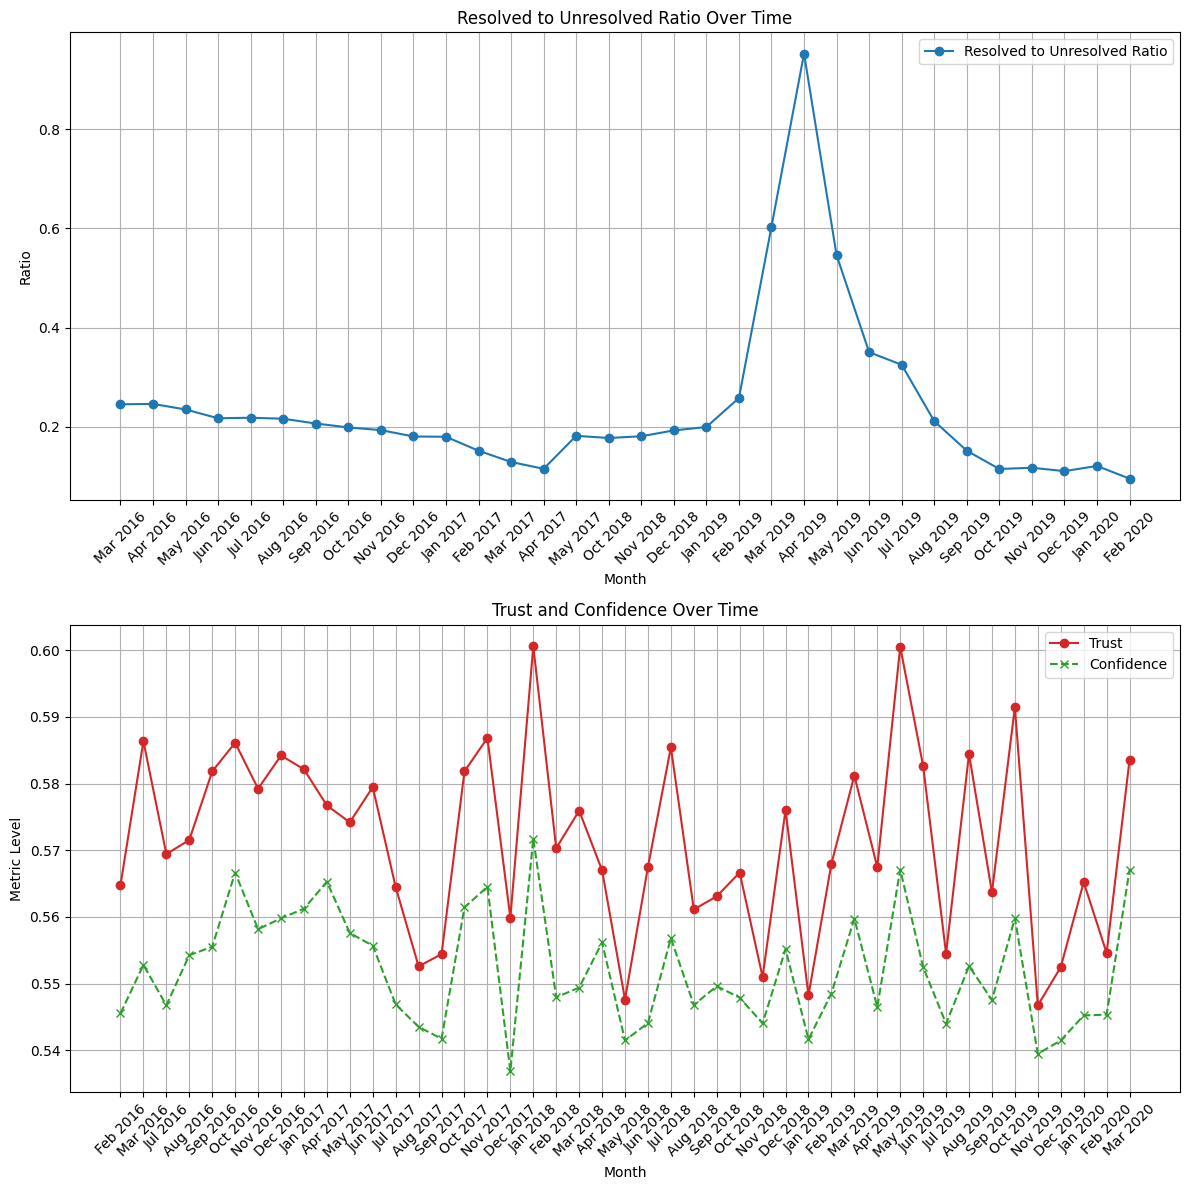

In [87]:
# instead of just resolved and unresolved, plot the ratio of resolved to unresolved crimes over time
# and make a subplot with trust and confidence over time just like above

outcomes_over_time['Resolved to Unresolved Ratio'] = outcomes_over_time['resolved'] / outcomes_over_time['unresolved']

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(outcomes_over_time['Month'], outcomes_over_time['Resolved to Unresolved Ratio'], color='tab:blue', marker='o', linestyle='-', label='Resolved to Unresolved Ratio')
ax[0].set_title('Resolved to Unresolved Ratio Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Ratio')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Trust'], color='tab:red', marker='o', linestyle='-', label='Trust')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Confidence'], color='tab:green', marker='x', linestyle='--', label='Confidence')
ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

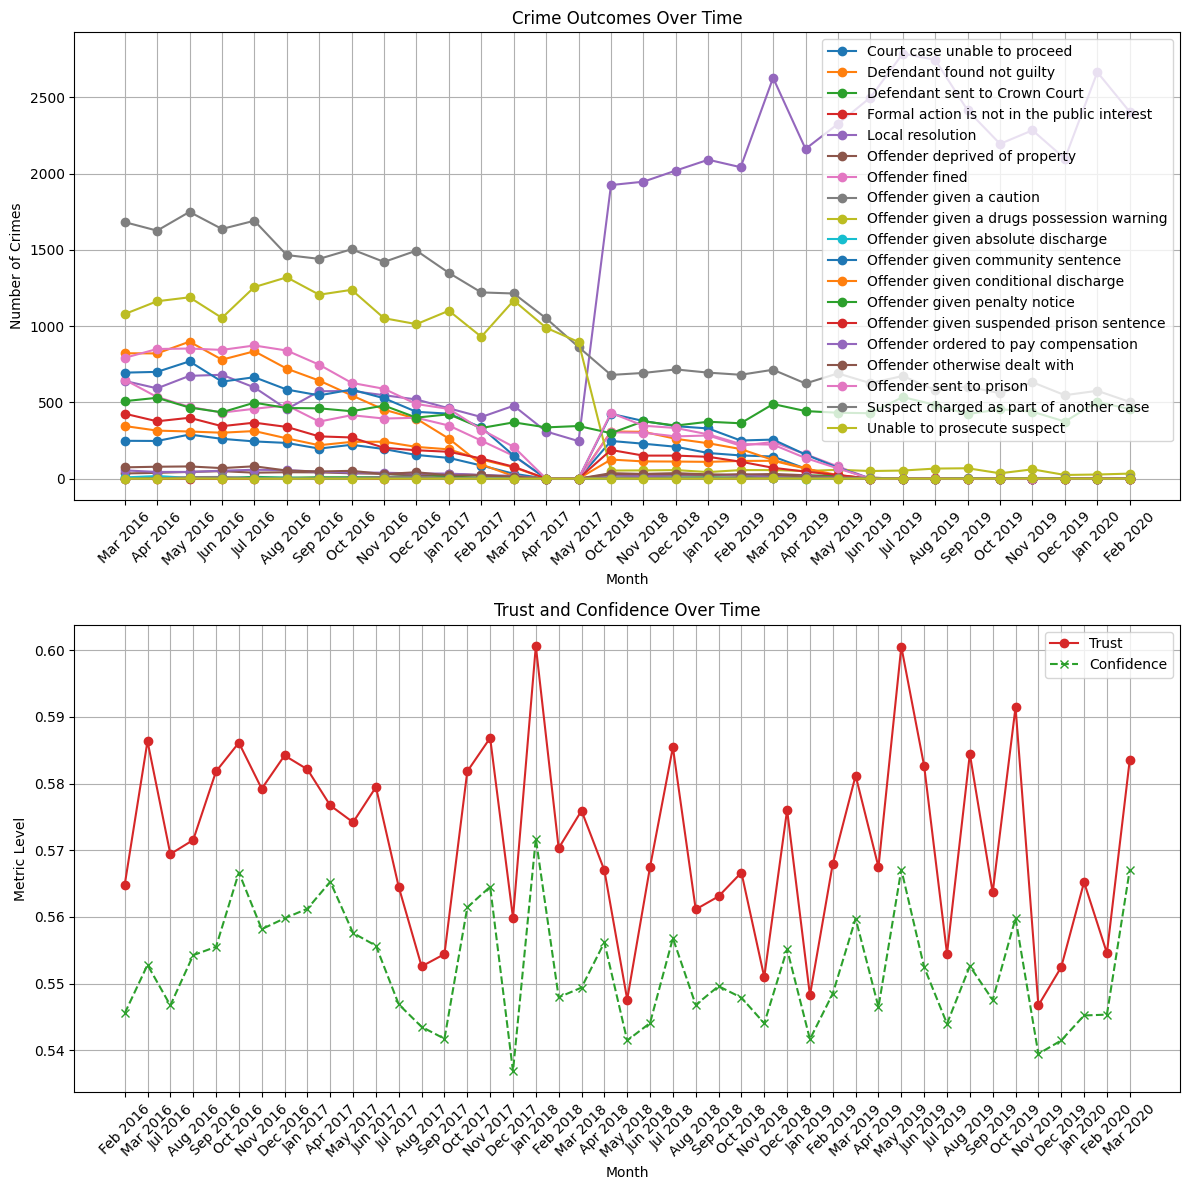

In [91]:
# now, instead of the ratio, plot different outcomes over time (except for 'Investigation complete; no suspect identified')
# and make a subplot with trust and confidence over time just like above

outcomes_over_time = crimes.groupby(['Month', 'Last outcome category']).size().reset_index(name='Count')
outcomes_over_time = outcomes_over_time.pivot(index='Month', columns='Last outcome category', values='Count').reset_index()
outcomes_over_time = outcomes_over_time.fillna(0)
outcomes_over_time['Month'] = pd.to_datetime(outcomes_over_time['Month'], format='%Y-%m')
outcomes_over_time = outcomes_over_time[(outcomes_over_time['Month'] > '2016-02-01') & (outcomes_over_time['Month'] < '2020-03-01')]
outcomes_over_time['Month'] = outcomes_over_time['Month'].dt.strftime('%b %Y')

outcomes_over_time = outcomes_over_time.drop(columns=['Investigation complete; no suspect identified'])
outcomes_over_time = outcomes_over_time.drop(columns=['Status update unavailable'])
outcomes_over_time = outcomes_over_time.drop(columns=['Court result unavailable'])
outcomes_over_time = outcomes_over_time.drop(columns=['Awaiting court outcome'])
outcomes_over_time = outcomes_over_time.drop(columns=['Under investigation'])

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
for col in outcomes_over_time.columns[1:]:
    ax[0].plot(outcomes_over_time['Month'], outcomes_over_time[col], marker='o', linestyle='-', label=col)

ax[0].set_title('Crime Outcomes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of Crimes')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Trust'], color='tab:red', marker='o', linestyle='-', label='Trust')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Confidence'], color='tab:green', marker='x', linestyle='--', label='Confidence')
ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


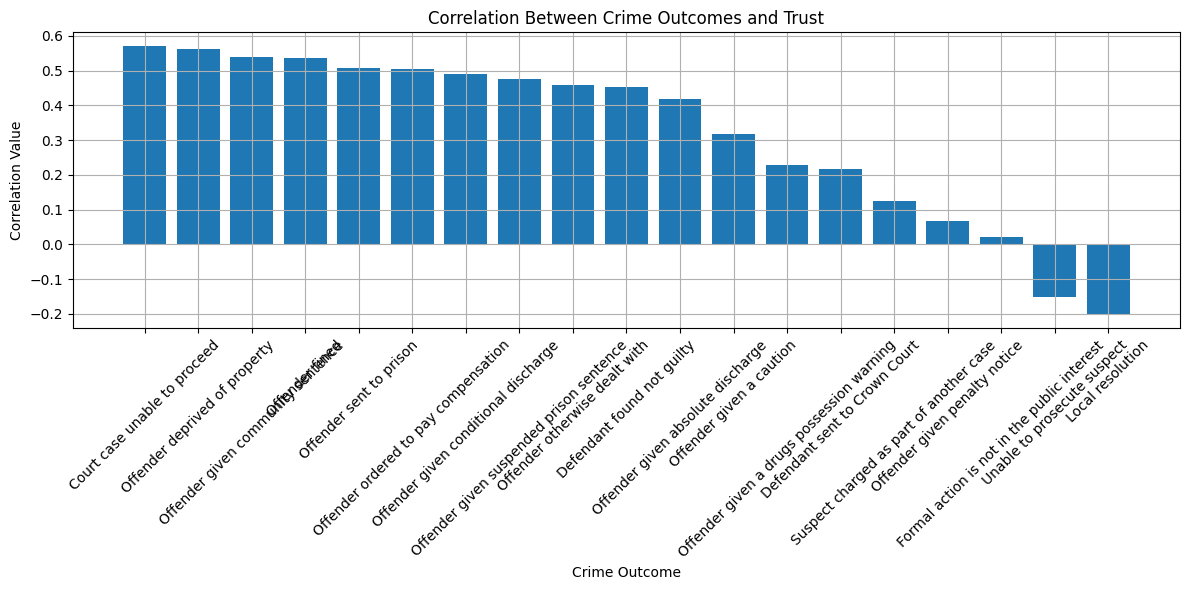

In [116]:
# Compute the correlation between the types of crime outcomes and trust and confidence
# and plot the correlation values in a bar chart
# ignore the date for now

outcomes_temp = outcomes_over_time.drop(columns=['Month'])
correlation_outcomes = outcomes_temp.corrwith(trust_conf_grouped['Trust']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Trust Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Trust Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Trust Correlation'], color='tab:blue')
plt.title('Correlation Between Crime Outcomes and Trust')
plt.xlabel('Crime Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

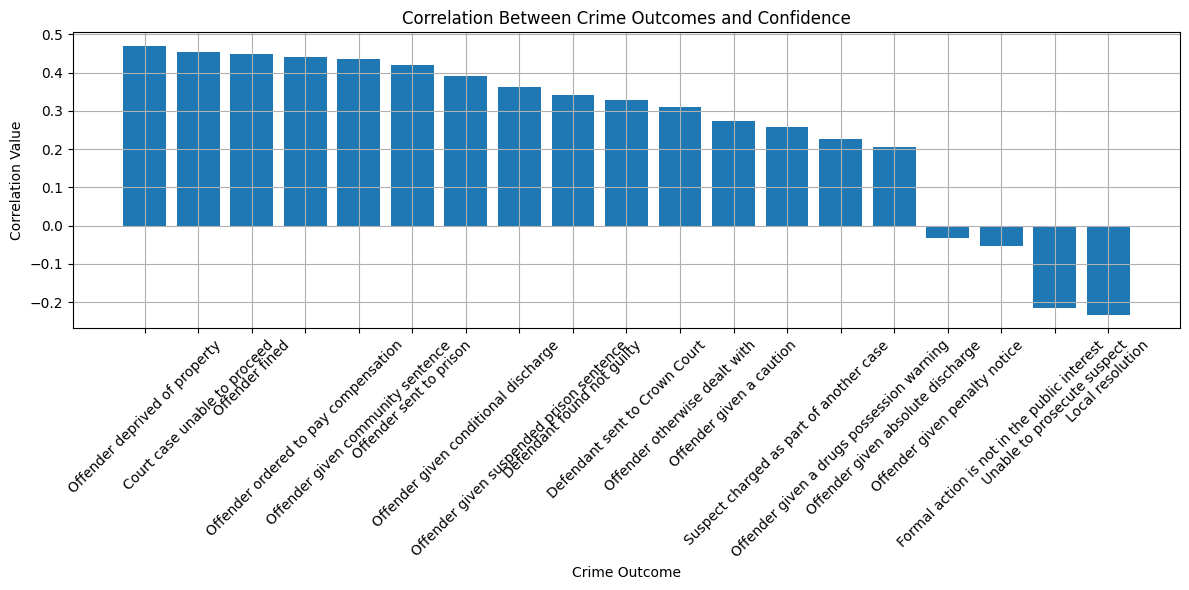

In [117]:
# Do the same for confidence

correlation_outcomes = outcomes_temp.corrwith(trust_conf_grouped['Confidence']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Confidence Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Confidence Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Confidence Correlation'], color='tab:blue')
plt.title('Correlation Between Crime Outcomes and Confidence')
plt.xlabel('Crime Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()